# How to plot spatial gene expression estimates created with the splotch DE workflow?



Load libraries

In [1]:
from __future__ import absolute_import, division, print_function
import os
import re
import glob
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import math
import seaborn as sns
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

In [2]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download: lambdas_pmeans_dapi.tsv, coordinate_registration_dapi.p, information_dapi.p

Load definitions

In [3]:
def read_array_metadata(metadata,filename,n_levels, extraplot=None):
    array_metadata = metadata[metadata['Count file'] == filename]
    array_levels = [array_metadata['Level %d'%(idx+1)].values[0] for idx in range(0,n_levels)]
    
    if extraplot != None:
        array_levels = array_metadata['Extra_plot_level'].tolist()
    return array_levels

def Extract(lst): 
    return list(next(zip(*lst))) 

def rename_lambdas_index(lambdas_file): 
    nwe=[]
    nm=lambdas_file.index
    for item in nm:
        nwe.append(str(item).split("_")[0])
    return nwe

In [4]:
# Load Lambda pmean df

path = '/Users/svickovi/Desktop/splotch/splotch_dapi_final'

# Read file
filename = os.path.join(path, 'lambdas_pmeans_dapi.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means.index = rename_lambdas_index(lambda_posterior_means)


In [5]:
lambda_posterior_means.head()

file          /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB_FL_HE_cortex/cortex/output_dapi_paper/Count_Tables/10015CN89_C1_stdata_adjusted.tsv  \
coordinate                                                                                                                                                              25_17   
0610007P14Rik                                -2.0246923500000014                                                                                                                
0610009B22Rik                                -2.3337002849999995                                                                                                                
0610009E02Rik                                 -4.462284200000001                                                                                                                
0610009L18Rik                                         -4.7809886                                                                                                                
0610009O20Rik                                 -3.502800645000002                                                                                                                

file                                                                          \
coordinate                   17_25                24_11                13_20   
0610007P14Rik  -1.9900269789999996  -2.0225399599999987  -1.9060239350000001   
0610009B22Rik         -2.442337895  -2.4019027799999995   -2.423463935000001   
0610009E02Rik   -4.140381550000003  -4.4583441499999985   -4.709734449999998   
0610009L18Rik   -4.656902750000004   -4.761487999999998   -5.278848899999999   
0610009O20Rik  -3.3778254600000013  -3.5711515000000005           -3.3924375   

file                                                                          \
coordinate                   21_16                29_21                29_29   
0610007P14Rik  -2.1006933100000005  -1.7009342000000007   -2.027341993800001   
0610009B22Rik   -2.328506205000001   -2.368083180000001   -2.107039470000001   
0610009E02Rik          -4.20999825   -4.423092650000002          -4.59903305   
0610009L18Rik          -4.77082495   -4.766674250000001   -5.212656499999998   
0610009O20Rik          -3.29949614  -3.4937816999999973  -3.8128799000000027   

file                                                                         \
coordinate                    5_20                17_12               27_28   
0610007P14Rik  -2.1764754189999995  -1.8703724699999997  -2.061873369999999   
0610009B22Rik   -2.501419580000002  -2.3779776209999985         -2.23693812   
0610009E02Rik           -4.9313039   -4.715000699999999  -4.574601849999998   
0610009L18Rik   -4.833812749999999   -5.188020849999999  -5.143909100000002   
0610009O20Rik  -3.5195538989999995  -3.5181921199999984  -3.876433299999998   

file           ...  \
coordinate     ...   
0610007P14Rik  ...   
0610009B22Rik  ...   
0610009E02Rik  ...   
0610009L18Rik  ...   
0610009O20Rik  ...   

file          /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB_FL_HE_cortex/cortex/output_dapi_paper/Count_Tables/10015CN90_E2_stdata_adjusted.tsv  \
coordinate                                                                                                                                                              19_18   
0610007P14Rik                                -2.1259517950000006                                                                                                                
0610009B22Rik                                -2.3845399749999996                                                                                                                
0610009E02Rik                                 -4.612474200000001                                                                                                                
0610009L18Rik                               

In [6]:
# Load coordinates registration file
reg_file = os.path.join(path, 'coordinate_registration_dapi.p')
registered_coordinates_dict = pickle.load(open(reg_file,'rb'), encoding='bytes') 


In [7]:
# Load sample_information file
info_file = os.path.join(path, 'information_dapi.p')
info = pickle.load(open(info_file,'rb'))   
metadata = info['metadata']
n_levels = info['n_levels']


In [8]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = numpy.exp(lambda_posterior_means-1)

## Plot a single gene across all different spatial arrays

In [9]:
# Pick a gene:
gene = 'Mbp'

assert gene in lambda_posterior_means.index, 'Error: %s not found!'%(gene)

# Pick variables to compare
variables_of_interest = ['M1']

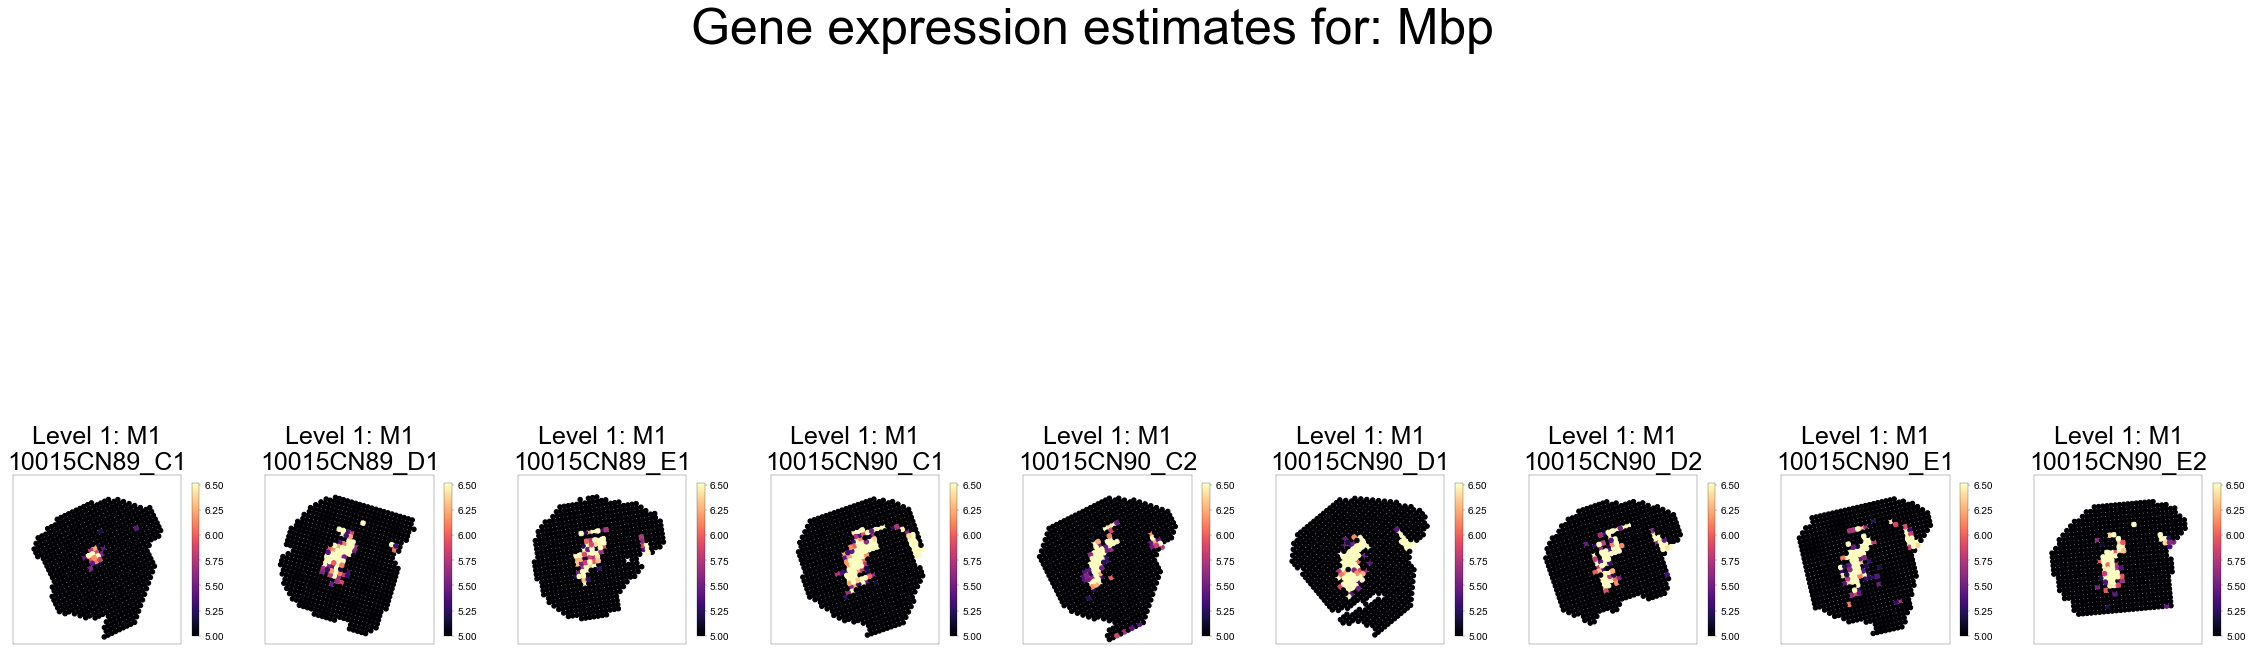

In [10]:
# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(40, 30))

num_cols = 9
# get the names of the count files
count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

axes = []
for j in range(0, num_cols):
    ax = plt.subplot2grid((int(len(count_files)/num_cols+1), num_cols), (0, j))
    axes.append(ax) 

# use the same color scale across the arrays
vmin,vmax = 5,numpy.percentile(lambda_posterior_means.loc[gene].values,95)

fig.suptitle("Gene expression estimates for: " + gene, fontsize=50)

# loop over the count files
for n,count_file in enumerate(count_files):
    ax = axes[n]

    coordinates = []
    for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
        if coordinate in registered_coordinates_dict[count_file]:
            
            coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
    coordinates = numpy.array(coordinates) 
    
    x_coordinates = coordinates[:,0]
    y_coordinates = coordinates[:,1]
    
    # rotation specific for DAPI samples
    ##  Rotation specific for DAPI 9 sections dataset
    alpha = 150
    x_coor_rot = math.cos(math.radians(alpha))* x_coordinates-math.sin(math.radians(alpha))*y_coordinates
    y_coor_rot = math.sin(math.radians(alpha))* x_coordinates+math.cos(math.radians(alpha))*y_coordinates 
    x_coor_rot2 = max(x_coor_rot)-x_coor_rot+min(x_coor_rot)
       
    s=20
    cbmap = ax.scatter(x_coor_rot2,y_coor_rot,
                       s=s,c=lambda_posterior_means[count_file].loc[gene],
                       cmap='magma',vmin=vmin,vmax=vmax,marker='o')
    
    ax.set_aspect('equal')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
        # put some information on the array in the title
    ax.set_title('%s\n%s'%(
                '\n'.join(['Level %d: %s'%(level_idx+1,level)
                       for level_idx,level in enumerate(list(map(str,read_array_metadata(metadata,count_file,n_levels))))]),count_file.split('/')[-1].split("_stdata_adjusted.tsv")[0]), fontsize=25)
    
    cbar = matplotlib.pyplot.colorbar(cbmap,ax=ax,shrink=0.2)
    cbar.ax.tick_params(labelsize=10) 
        
fig.subplots_adjust(top=0.90)

## View multiple genes at once in a CCF system

In [11]:
# Pick genes:
genes = ['Nxph4','Doc2a', 'Slc18a2', 'Cabp7','Ptpn4','Scn5a', 'Dkkl1', 'Mbp']

for gene in genes:
    assert gene in lambda_posterior_means.index, 'Error: %s not found!'%(gene)

# Pick variables to compare
variables_of_interest = ['M1']
naming_dict = {'M1':'Cortex DAPI samples, splotch_one_level'}

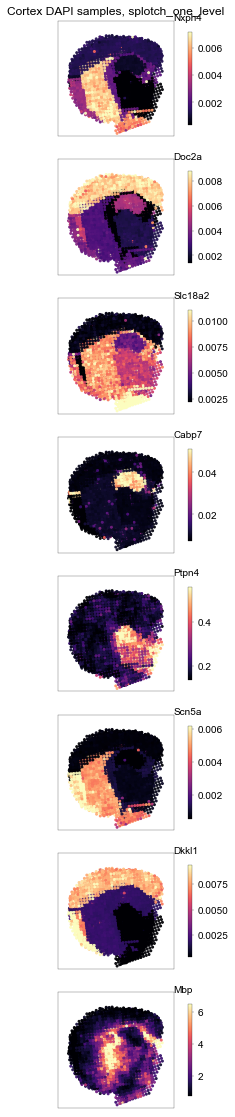

In [12]:
# initialize a figure
fig = matplotlib.pyplot.figure()
fig.set_size_inches([len(variables_of_interest)*5,20])

axes = []
for i in range(len(genes)):
    for ax_idx in range(len(variables_of_interest)):
        ax = plt.subplot2grid((len(genes), len(variables_of_interest)), (i, ax_idx))
        axes.append(ax)                    

for gidx, gene in enumerate(genes):
    
    # get the names of the count files
    count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))
    
    #count_files = count_files[0:2]

    # use the same color scale across the arrays
    #vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)
    vmin = numpy.percentile(lambda_posterior_means.loc[gene].values,5)
    vmax = numpy.percentile(lambda_posterior_means.loc[gene].values,95)
    
    # adjust the axes
    for ax_idx in range(0,len(variables_of_interest)):
        
        if gidx == 0:
            axes[ax_idx +(gidx*len(variables_of_interest))].set_title(naming_dict[variables_of_interest[ax_idx]])
    
        axes[ax_idx +(gidx*len(variables_of_interest))].set_aspect('equal')
    
        axes[ax_idx +(gidx*len(variables_of_interest))].set_xticks([])
        axes[ax_idx +(gidx*len(variables_of_interest))].set_yticks([])
    
        axes[ax_idx +(gidx*len(variables_of_interest))].set_xlim([-20,20])
        axes[ax_idx +(gidx*len(variables_of_interest))].set_ylim([-20,20])

    cbmap = [None for _ in range(0,len(variables_of_interest))]
    
    # loop over the count files
    for n,count_file in enumerate(count_files):
    
        # see if the current array has the level variable of interest
        try:
            #ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
            ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
        except ValueError:
            continue
        
        # move to the next array if the current array has not been registered 
        if count_file not in registered_coordinates_dict:
            continue
    
        # for each ST spot on the array, let us get its registered coordinate if available
        coordinates_found = numpy.zeros(len(list(lambda_posterior_means[count_file].columns))) # indicator of being registered
        coordinates = []  
        for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
            if coordinate in registered_coordinates_dict[count_file]:
                coordinates_found[coord_idx] = 1
                coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
        coordinates = numpy.array(coordinates)
        
        x_coordinates = coordinates[:,0]
        y_coordinates = coordinates[:,1]
        
        ##  Rotation specific for DAPI 9 sections dataset
        alpha = 150
        x_coor_rot = math.cos(math.radians(alpha))* x_coordinates-math.sin(math.radians(alpha))*y_coordinates
        y_coor_rot = math.sin(math.radians(alpha))* x_coordinates+math.cos(math.radians(alpha))*y_coordinates 
        x_coor_rot2 = max(x_coor_rot)-x_coor_rot+min(x_coor_rot)
        
        # visualize the registered ST spots
        cbmap[ax_idx] = axes[ax_idx +(gidx*len(variables_of_interest))].scatter(x_coor_rot2,y_coor_rot,
                               s=4, c=lambda_posterior_means[count_file].loc[gene][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o',alpha=0.9)

    # add colorbars
    for ax_idx in range(0, len(variables_of_interest)):
        if cbmap[ax_idx] is not None:
            cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=axes[ax_idx +(gidx*len(variables_of_interest))],shrink=0.8)    
            #cbar.set_label(r'%s $\bar{\lambda}$'%(gene))
    
    # Set gene name
    uu = 0
    axes[uu +(gidx*len(variables_of_interest))].text(20, 20, gene, fontsize=10)


# Plot individually sections

In [75]:
# Pick genes:
regions = ['CTXSP', 'HIP', 'HY', 'ISOCORTEX', 'TH','PIR']  #'TH', 'CNU', 'PIR' 
#genes = ['Nr2f2','Cabp7','Sema4g','Dkkl1','Slc17a6', 'Penk', 'Grem2'] 
genes = ['Adora2a', 'Cabp7','Slc6a11', 'Ier5', 'Slc17a6', 'Grem2']

# Pick variables to compare
variables_of_interest = ['M1']

In [76]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [77]:
aba_path = '/Users/svickovi/Desktop/splotch/jpg_he'
ABA_HE = [aba_path + '/' + genes[0] + '.jpg',
         aba_path + '/' + genes[1] + '.jpg',
         aba_path + '/' + genes[2] + '.jpg',
         aba_path + '/' + genes[3] + '.jpg',
         aba_path + '/' + genes[4] + '.jpg',
         aba_path + '/' + genes[5] + '.jpg',]
         #aba_path + '/' + genes[6] + '.jpg']


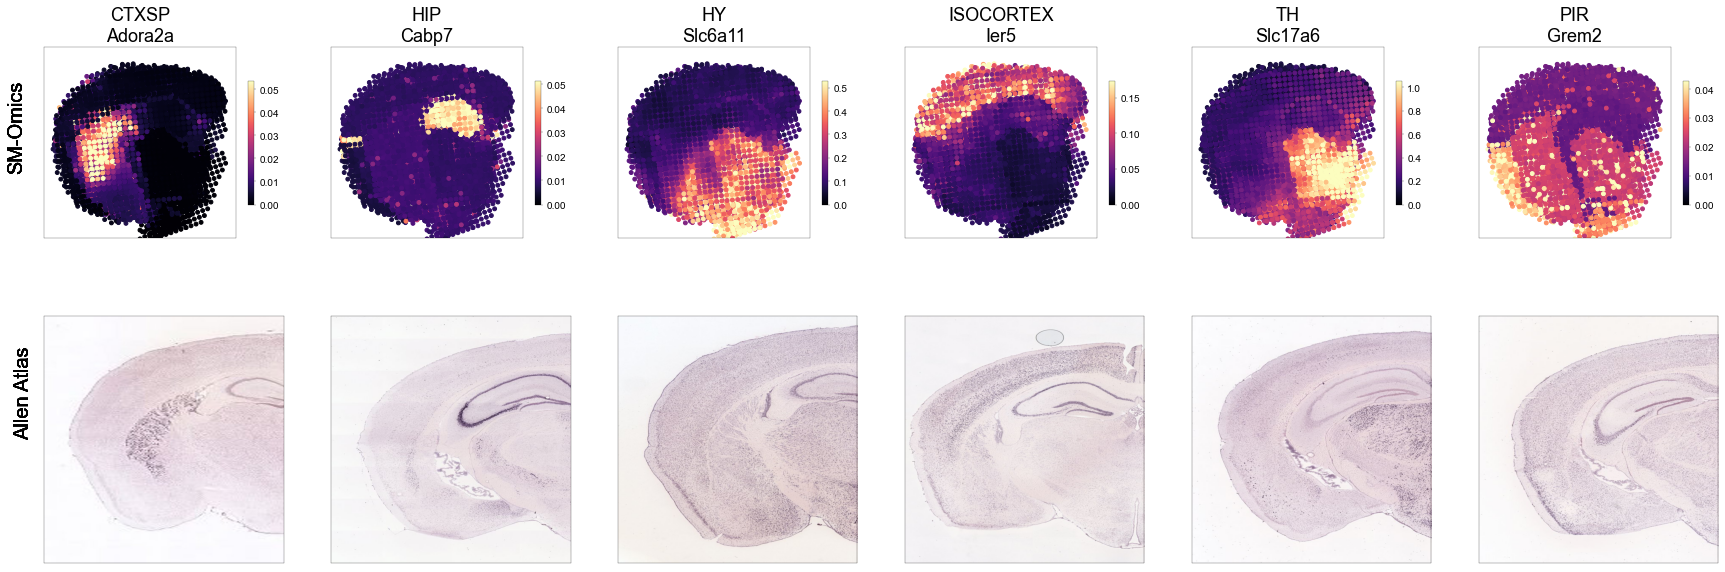

In [84]:
## Same, but one gene in each figure, ie. no subplots

# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(30, 10))

axes = []
for ax_idx in range(0,2):
    for i in range(len(genes)):
        ax = plt.subplot2grid((2, len(genes)), (ax_idx, i))
        axes.append(ax)                    


############# SPLOTCH ############# 
for gidx, gene in enumerate(genes):
    
    # get the names of the count files
    count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

    # use the same color scale across the arrays
    vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)
           
    
    axes[gidx].set_aspect('equal')
    
    axes[gidx].set_xticks([])
    axes[gidx].set_yticks([])
    
    axes[gidx].set_xlim([-18,18])
    axes[gidx].set_ylim([-18,18])

    cbmap = [None for _ in range(0,len(genes))]
    
    # loop over the count files
    for n,count_file in enumerate(count_files):
    
        # see if the current array has the level variable of interest
        try:
            #ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
            ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
        except ValueError:
            continue
        
        # move to the next array if the current array has not been registered 
        if count_file not in registered_coordinates_dict:
            continue
    
        # for each ST spot on the array, let us get its registered coordinate if available
        coordinates_found = numpy.zeros(len(list(lambda_posterior_means[count_file].columns))) # indicator of being registered
        coordinates = []  
        for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
            if coordinate in registered_coordinates_dict[count_file]:
                coordinates_found[coord_idx] = 1
                coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
        coordinates = numpy.array(coordinates)
        x_coordinates = coordinates[:,0]
        y_coordinates = coordinates[:,1]

        ##  Rotation specific for DAPI 9 sections dataset
        alpha = 150
        x_coor_rot = math.cos(math.radians(alpha))* x_coordinates-math.sin(math.radians(alpha))*y_coordinates
        y_coor_rot = math.sin(math.radians(alpha))* x_coordinates+math.cos(math.radians(alpha))*y_coordinates 
        x_coor_rot2 = max(x_coor_rot)-x_coor_rot+min(x_coor_rot)

        # visualize the registered ST spots
        cbmap[gidx] = axes[gidx].scatter(x_coor_rot2,y_coor_rot,
                               s=15, c=lambda_posterior_means[count_file].loc[gene][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o')

    # add colorbars
    for ax_idx in range(0, len(genes)):
        if cbmap[ax_idx] is not None:
            cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=axes[gidx],shrink=0.5)    
            #cbar.set_label(r'%s $\bar{\lambda}$'%(gene))
     
    # Set sub labels
    axes[0].text(-25, -5, 'SM-Omics', fontsize=20,  rotation=90)
    
    # Set gene name
    uu =0
    axes[gidx].set_title(regions[gidx] + '\n' + gene, fontsize=18)
    
############# ABA expression ############# 

for j, genej in enumerate(genes):
    
    # read the tissue image
    tissue_image = Image.open(ABA_HE[j])
    tissue_image = matplotlib.pyplot.imread(ABA_HE[j])
    # take only half 
        
    # visualize the tissue image
    axes[j+len(genes)].imshow(tissue_image[:,0:round(numpy.size(tissue_image,0)/2)+100])
    #axes[j+len(genes)].imshow(tissue_image)
    axes[j+len(genes)].set_aspect('auto')
    
    axes[j+len(genes)].set_xticks([])
    axes[j+len(genes)].set_yticks([])
    
    # Set sublabels
    axes[len(genes)].text(-80, 500, 'Allen Atlas', fontsize=20,  rotation=90)
    
#plt.tight_layout()
#plt.show()
plt.savefig('../../figures/SM_Visium_aba_mrna_splotch.pdf')#,transparent=True, bbox_inches = 'tight',
   #pad_inches = 0, dpi=1200, rasterized=True)
